In [2]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchsummary import summary


In [3]:
# Define transform for preprocessing (normalize the data)
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download the MNIST dataset
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Calculate the sizes for train, validation, and test splits
total_size = len(mnist_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  # To ensure all data is used

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(mnist_dataset, [train_size, val_size, test_size])

batch_size = 128

# Create data loaders for each dataset (optional, for batch processing)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 48000
Validation dataset size: 6000
Test dataset size: 6000


torch.Size([1, 28, 28])
torch.Size([28, 28])


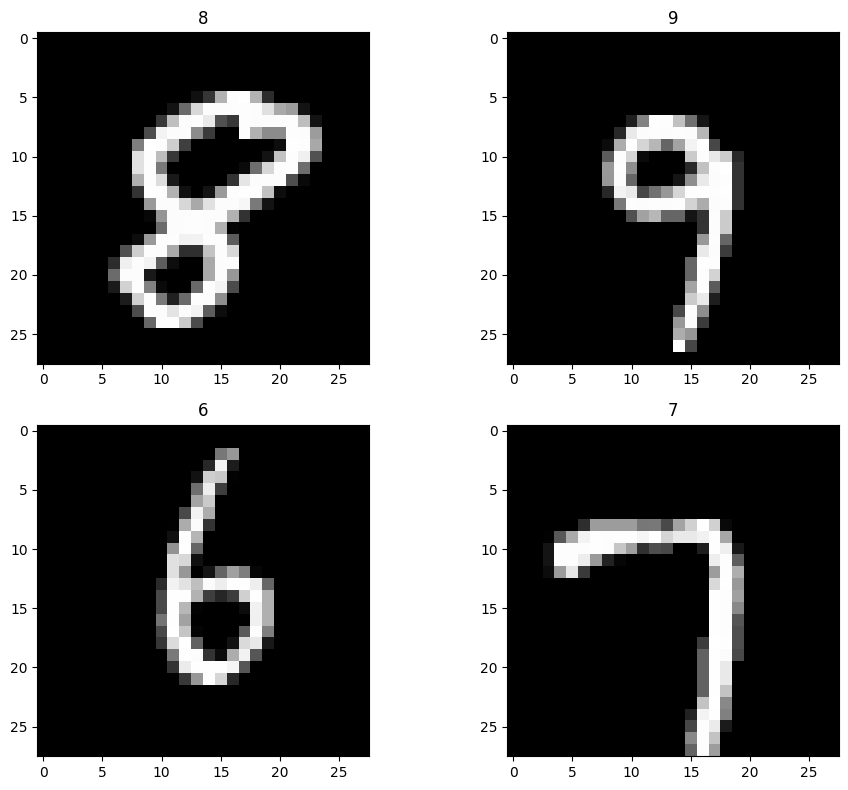

In [24]:
for images, labels in train_loader:
    # Access images and labels
    #print(images.shape)  # (batch_size, 1, 28, 28)
    #print(labels.shape)  # (batch_size)

    # Display images and labels for the first batch (4)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

    # Remove batch dimension for single image
    print(images[0].shape)
    print(images[0].squeeze().shape)

    axes[0, 0].imshow(images[0].squeeze(), cmap='gray')
    axes[0, 1].imshow(images[1].squeeze(), cmap='gray')
    axes[1, 0].imshow(images[2].squeeze(), cmap='gray')
    axes[1, 1].imshow(images[3].squeeze(), cmap='gray')

    axes[0, 0].set_title(f'{labels[0]}')
    axes[0, 1].set_title(f'{labels[1]}')
    axes[1, 0].set_title(f'{labels[2]}')
    axes[1, 1].set_title(f'{labels[3]}')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the figure
    plt.show()

    break

In [25]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(7 * 7 * 64, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = x.view(-1, 7 * 7 * 64)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Create an instance of the model
model = SimpleCNN()

# Number of params
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 421642


In [26]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu") 
    print("GPU is not available")

model.to(device)

GPU is available


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [27]:
# Print the summary of the model
summary(model, input_size=(1, 28, 28))  # Example for MNIST

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 1.61
Estimated Total Size (MB): 2.26
-------------------------------------------

In [28]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 5

In [29]:
accuracy_list = [] # Per epoch

loss_list = [] # Per batch

def calculate_accuracy(loader, model, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get class with highest score
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()  # Reset model to training mode
    return 100 * correct / total

In [30]:
# Training loop
for epoch in range(num_epochs):
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    model.train()  # Set the model to training mode
    
    for i, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update tqdm description with loss value after 20 batches
        if i % (batch_size * 20) == 0:
            progress_bar_loss = loss.item()
        progress_bar.set_postfix(loss=progress_bar_loss)

        loss_list.append(loss.item())
    
    # Validation step
    model.eval()  # Set the model to evaluation mode
    val_accuracy = calculate_accuracy(val_loader, model, device)
    accuracy_list.append(val_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_accuracy:.2f}%")

    # Save the model checkpoint after each epoch
    #torch.save(model.state_dict(), f"checkpoint_epoch_{epoch}.pth")

# Evaluate the model on the test set after training
model.eval()  # Set the model to evaluation mode
test_accuracy = calculate_accuracy(test_loader, model, device)
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Epoch 1/5: 100%|██████████| 375/375 [00:06<00:00, 58.44it/s, loss=2.3]


Epoch 1/5, Validation Accuracy: 97.02%


Epoch 2/5: 100%|██████████| 375/375 [00:06<00:00, 55.80it/s, loss=0.0363]


Epoch 2/5, Validation Accuracy: 97.57%


Epoch 3/5: 100%|██████████| 375/375 [00:06<00:00, 56.40it/s, loss=0.148]


Epoch 3/5, Validation Accuracy: 98.27%


Epoch 4/5: 100%|██████████| 375/375 [00:06<00:00, 54.03it/s, loss=0.0126]


Epoch 4/5, Validation Accuracy: 98.50%


Epoch 5/5: 100%|██████████| 375/375 [00:07<00:00, 53.31it/s, loss=0.03]


Epoch 5/5, Validation Accuracy: 98.53%
Final Test Accuracy: 98.73%


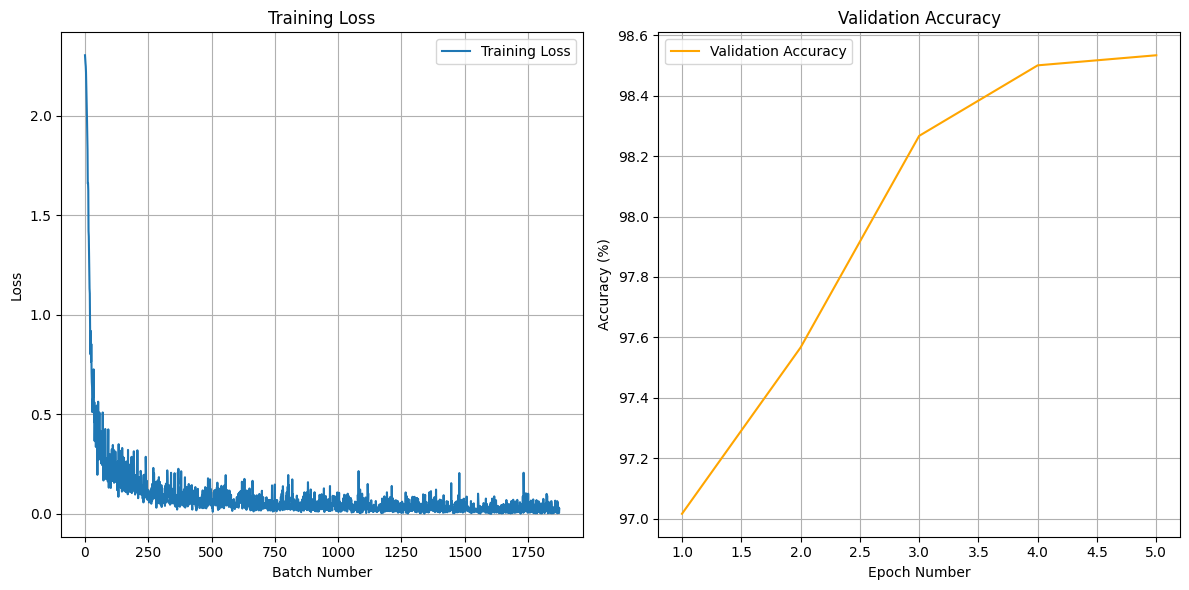

In [31]:
# Assuming `loss_list` and `accuracy_list` were populated during training:
# - `loss_list` contains the training losses for each batch
# - `accuracy_list` contains validation accuracies for each epoch

# Generate x-axis values
epochs = list(range(1, num_epochs + 1))

# Plot training loss
plt.figure(figsize=(12, 6))

# Subplot 1: Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(len(loss_list)), loss_list, label='Training Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid()

# Subplot 2: Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_list, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()

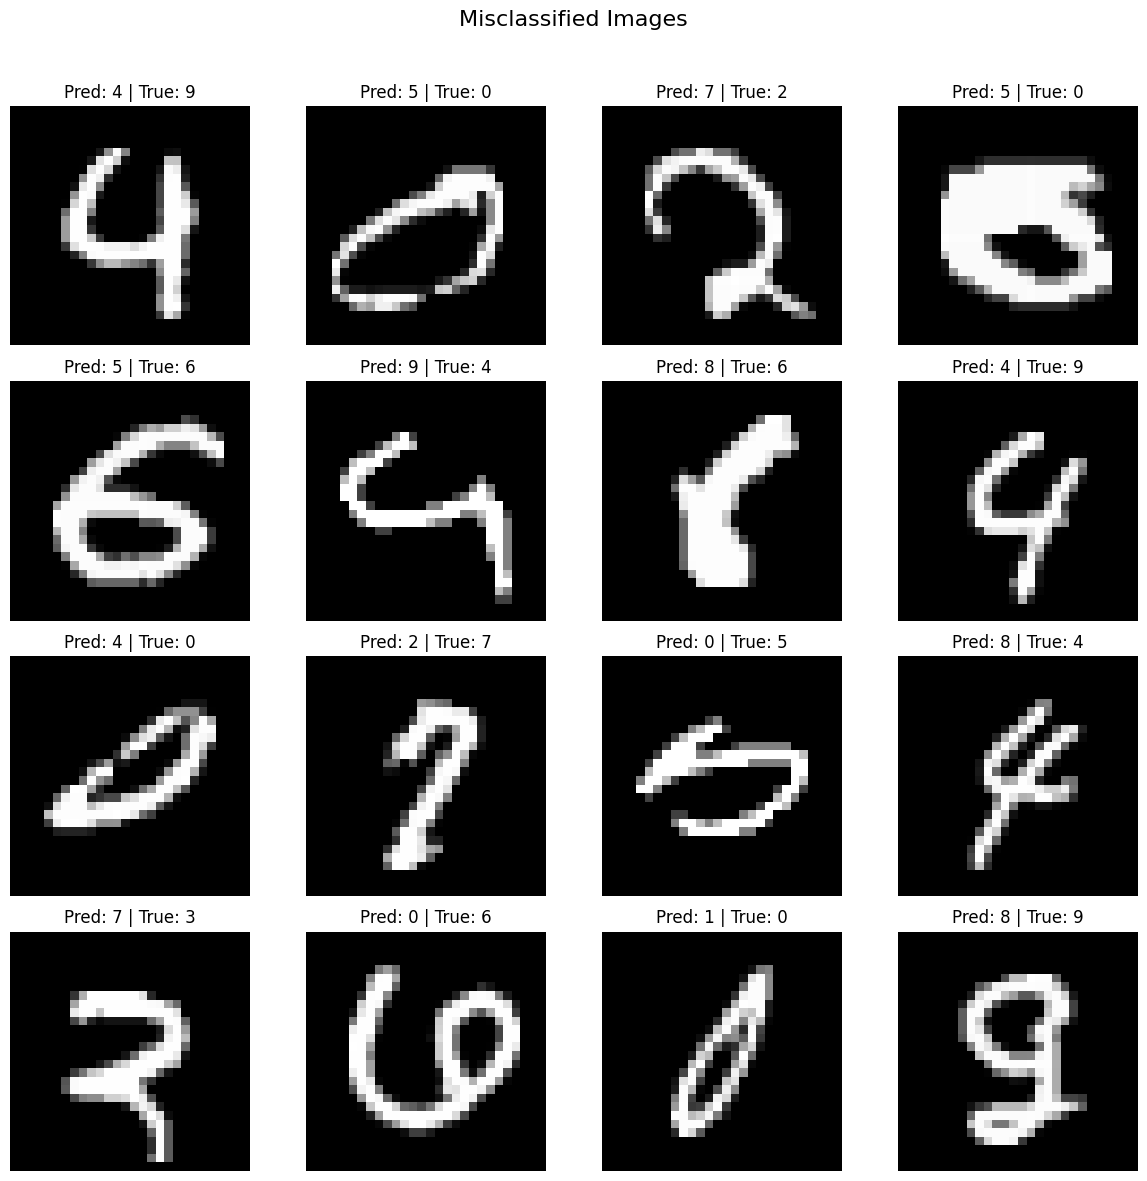

In [32]:
# Function to find and plot misclassified examples
def plot_misclassified_images(model, test_loader, device, num_images=16):
    model.eval()  # Set the model to evaluation mode
    misclassified_images = []
    misclassified_labels = []
    correct_labels = []

    # Iterate through the test dataset
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Collect misclassified examples
            misclassified = (predicted != labels)
            misclassified_images.extend(images[misclassified].cpu())
            misclassified_labels.extend(predicted[misclassified].cpu())
            correct_labels.extend(labels[misclassified].cpu())

            # Stop if we have enough examples
            if len(misclassified_images) >= num_images:
                break

    # Limit to the requested number of images
    misclassified_images = misclassified_images[:num_images]
    misclassified_labels = misclassified_labels[:num_images]
    correct_labels = correct_labels[:num_images]

    # Plot the images
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle('Misclassified Images', fontsize=16)
    for i, ax in enumerate(axes.flat):
        if i < len(misclassified_images):
            img = misclassified_images[i].squeeze().numpy()  # Remove channel dimension
            ax.imshow(img, cmap='gray')
            ax.set_title(f"Pred: {misclassified_labels[i]} | True: {correct_labels[i]}")
            ax.axis('off')
        else:
            ax.axis('off')  # Hide extra subplots

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Call the function
plot_misclassified_images(model, test_loader, device, num_images=16)

In [36]:
# Save the model's state dictionary (only model weights)
def save_model(model, file_path='model.pth'):
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to {file_path}")

save_model(model, 'model.pth')

Model saved to model.pth
